In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/insurance/insurance.csv


In [2]:
import pandas as pd

df = pd.read_csv("/kaggle/input/insurance/insurance.csv")
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## Data cleaning

First, let's check the total number of NAs:

In [3]:
print(f"Total NA values: {df.isna().sum().sum()}")

Total NA values: 0


In [4]:
df.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

In [5]:
for col in 'sex', 'smoker', 'region':
  print(f"{col}\n{df[col].value_counts()}\n")

sex
sex
male      676
female    662
Name: count, dtype: int64

smoker
smoker
no     1064
yes     274
Name: count, dtype: int64

region
region
southeast    364
southwest    325
northwest    325
northeast    324
Name: count, dtype: int64



In [6]:
for col in 'sex', 'smoker', 'region':
  df[col] = df[col].astype('category')

In [7]:
df.dtypes

age            int64
sex         category
bmi          float64
children       int64
smoker      category
region      category
charges      float64
dtype: object

## EDA

<Axes: >

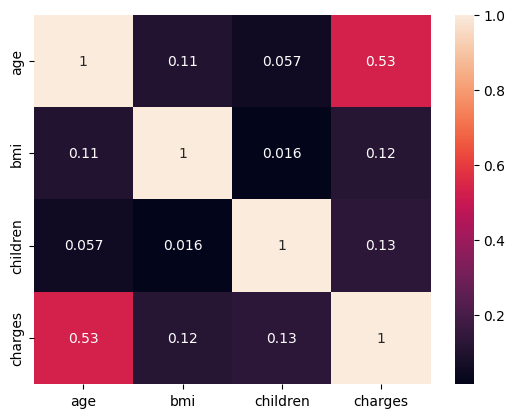

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

corr = df.corr('spearman', numeric_only=True)
sns.heatmap(corr, annot=True) #ax=ax)

Charges correlate strongly with age. Unfortunately, the older you are, the more expensive it is for you to stay alive.
Next, let's plot the distribution of the target variable with respect to the categorical features.

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


Text(0.5, 0, 'USA region')

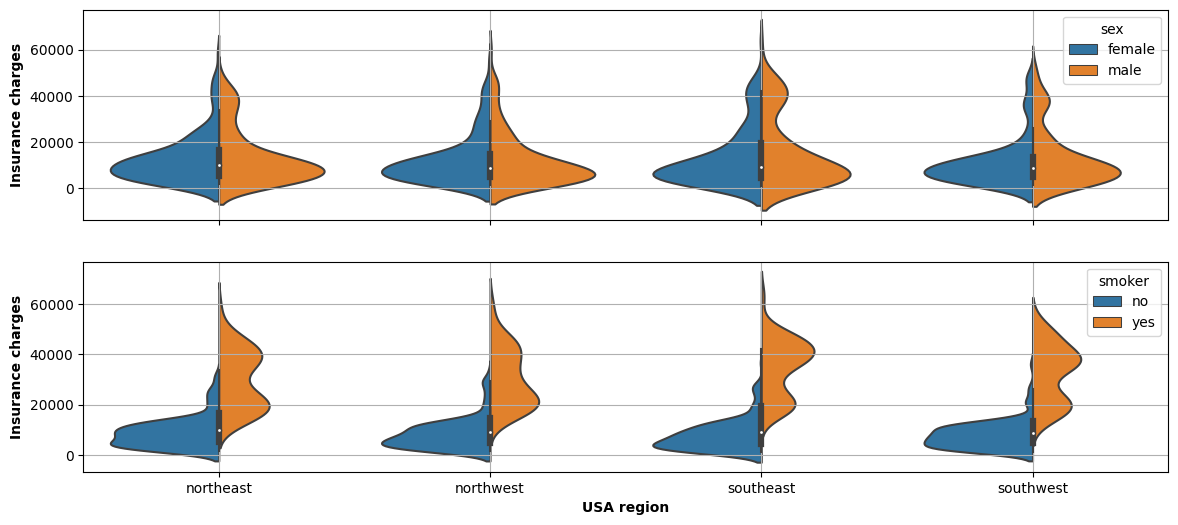

In [9]:
fig, axes = plt.subplots(nrows=2, figsize=(14,6), sharex=True)

for hue, ax in zip(['sex', 'smoker'], axes):
  sns.violinplot(data=df, x='region', y='charges', hue=hue, split=True, ax=ax)
  ax.grid()
  ax.set_ylabel("Insurance charges", fontweight='bold')
  ax.set_xlabel(None)
ax.set_xlabel("USA region", fontweight='bold')

There is a slight dependence on sex and region. 
But the main feature is smoking. Smokers pay not only for tobacco, but also for expensive insurance. How many smokers are in this dataset?

In [10]:
df['smoker'].value_counts()

smoker
no     1064
yes     274
Name: count, dtype: int64

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1057: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = data.groupby(
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping

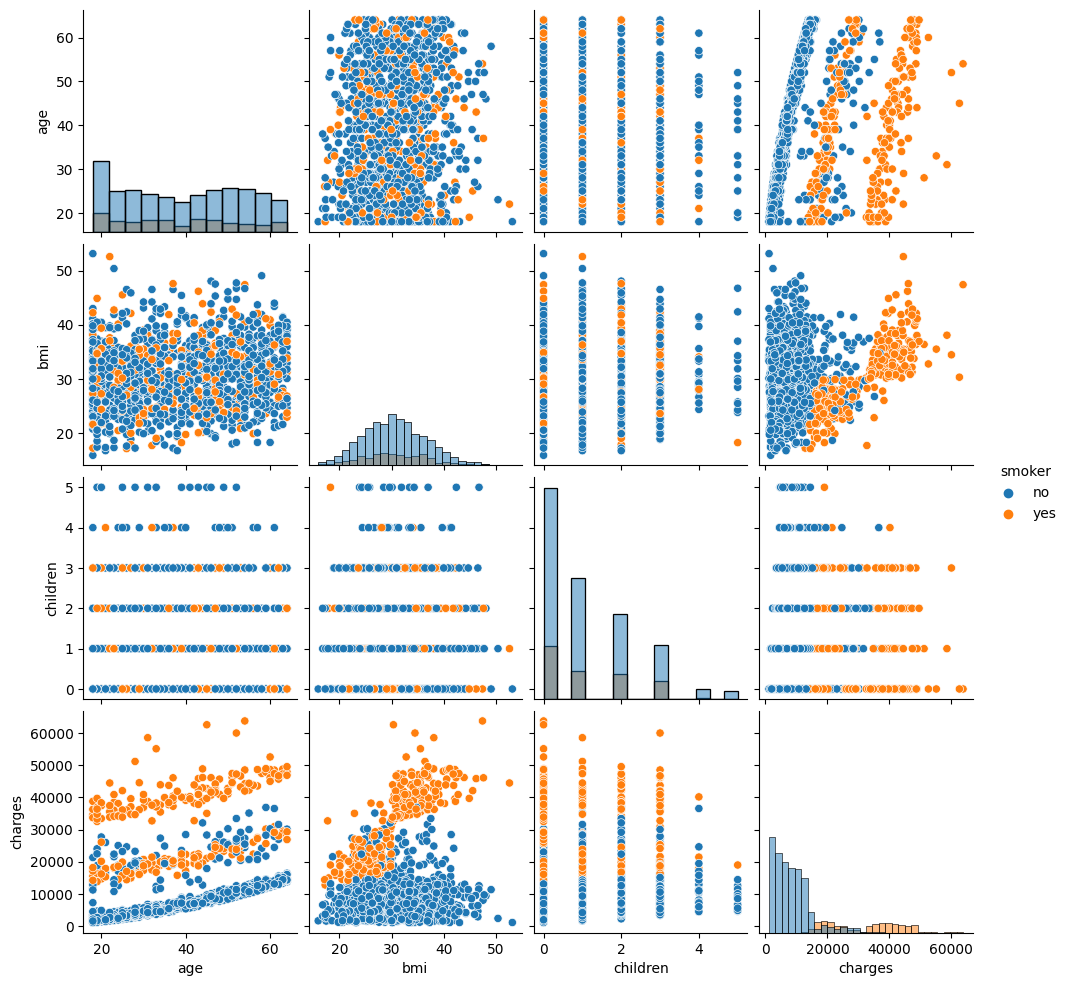

In [11]:
ax = sns.pairplot(df, vars=['age', 'bmi', 'children', 'charges'], hue='smoker',
                  diag_kind='hist')#, ax=ax)

There are clear groups of people with different habits (smoking, BMI, children) who have different insurance bands.

## ML-specific preprocessing

In [12]:
df = pd.get_dummies(df, columns=['smoker', 'sex', 'region'], drop_first=True)
df.head()

,age,bmi,children,charges,smoker_yes,sex_male,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,True,False,False,False,True
1,18,33.770,1,1725.55230,False,True,False,True,False
2,28,33.000,3,4449.46200,False,True,False,True,False
3,33,22.705,0,21984.47061,False,True,True,False,False
4,32,28.880,0,3866.85520,False,True,True,False,False


In [13]:
import numpy as np
from sklearn.model_selection import train_test_split

print("Before:")
print(f"\tData: {df.shape}")

train, test = train_test_split(df, test_size=0.3, random_state = 42)

print("After:")
print(f"\tTrain: {train.shape}")
print(f"\tTest: {test.shape}")

Before:
	Data: (1338, 9)
After:
	Train: (936, 9)
	Test: (402, 9)


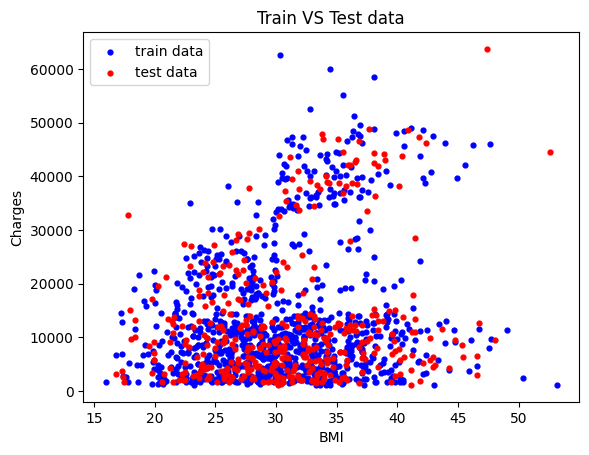

In [14]:
plt.scatter(train['bmi'], train['charges'], color='b', s=12, label='train data')
plt.scatter(test['bmi'], test['charges'], color='r', s=12, label='test data')
plt.xlabel('BMI')
plt.ylabel('Charges')
plt.legend()
plt.title('Train VS Test data')
plt.show()

In [15]:
from sklearn.preprocessing import PowerTransformer

cols = ['age', 'bmi', 'charges']
scaler = PowerTransformer().fit(train[cols])

for data in train, test:
  data[cols] = scaler.transform(data[cols])

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


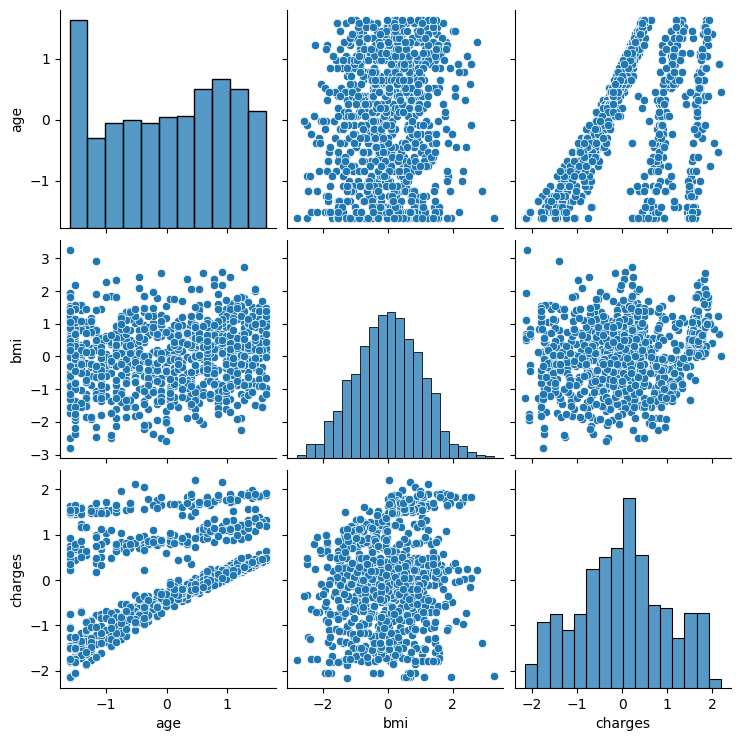

In [16]:
sns.pairplot(train, vars=cols)

In [17]:
Ytrain, Ytest = train['charges'], test['charges']
features = [x for x in df.columns if x != 'charges']
Xtrain, Xtest = train[features].values, test[features].values

assert Xtrain.shape[0] == Ytrain.shape[0] and Xtest.shape[0] == Ytest.shape[0]
assert Xtrain.shape[1] == Xtest.shape[1] == df.shape[1] - 1

## Linear Regression

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score, mean_squared_error

# Create and train the model using the gradient descent
lm = LinearRegression().fit(Xtrain, Ytrain)

for name, X, Y in ("train", Xtrain, Ytrain), ("test", Xtest, Ytest):
  Ypred = lm.predict(X)
  mae = np.abs(Y - Ypred).mean()
  skmae = mean_absolute_error(Y, Ypred)
  print(f"{name}: {mae:.4f} (ours), {skmae:.4f} (sklearn)")

train: 0.3085 (ours), 0.3085 (sklearn)
test: 0.2899 (ours), 0.2899 (sklearn)


In [19]:
r2_score(Y, Ypred)

0.7891356055981564

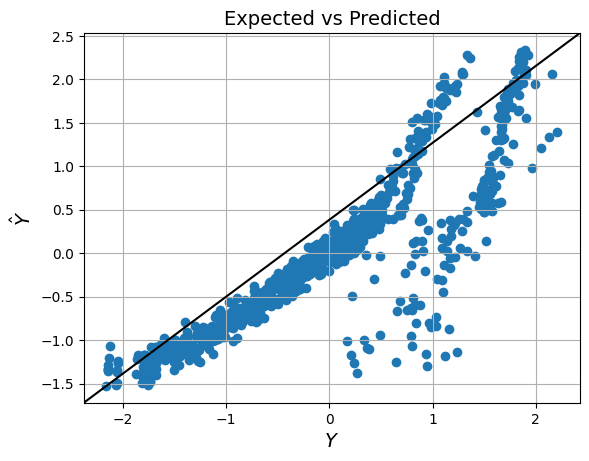

In [20]:
plt.scatter(Ytrain, lm.predict(Xtrain))
plt.grid() 
plt.xlabel("$Y$", fontweight='bold', fontsize=14) 
plt.ylabel("$\hat{Y}$", fontweight='bold', fontsize=14) 
plt.title("Expected vs Predicted", fontsize=14) 

# Diagonal line
ax = plt.gca()
ax.plot([0, 1], [0, 1], color='black', transform=ax.transAxes)


As we can see, there is a large group of people who cannot be correctly predicted with a simple linear model. 

## Regularized LM

In [21]:
from sklearn.linear_model import Lasso, Ridge, ElasticNet

alpha = 0.1
models = {
    "OLS": LinearRegression().fit(Xtrain, Ytrain),
    "Lasso": Lasso(alpha=alpha).fit(Xtrain, Ytrain),
    "Ridge": Ridge(alpha=alpha * 1_000).fit(Xtrain, Ytrain),
    "Elastic Net": ElasticNet(alpha=alpha).fit(Xtrain, Ytrain)
}

# Train and print metrics
for name, X, Y in ("train", Xtrain, Ytrain), ("test", Xtest, Ytest):
  print(name)
  for mtype, model in models.items():
    mae = mean_absolute_error(Y, model.predict(X))
    print(f"\t{mtype}: {mae:.3f}")

train
	OLS: 0.309
	Lasso: 0.398
	Ridge: 0.408
	Elastic Net: 0.398
test
	OLS: 0.290
	Lasso: 0.388
	Ridge: 0.399
	Elastic Net: 0.388


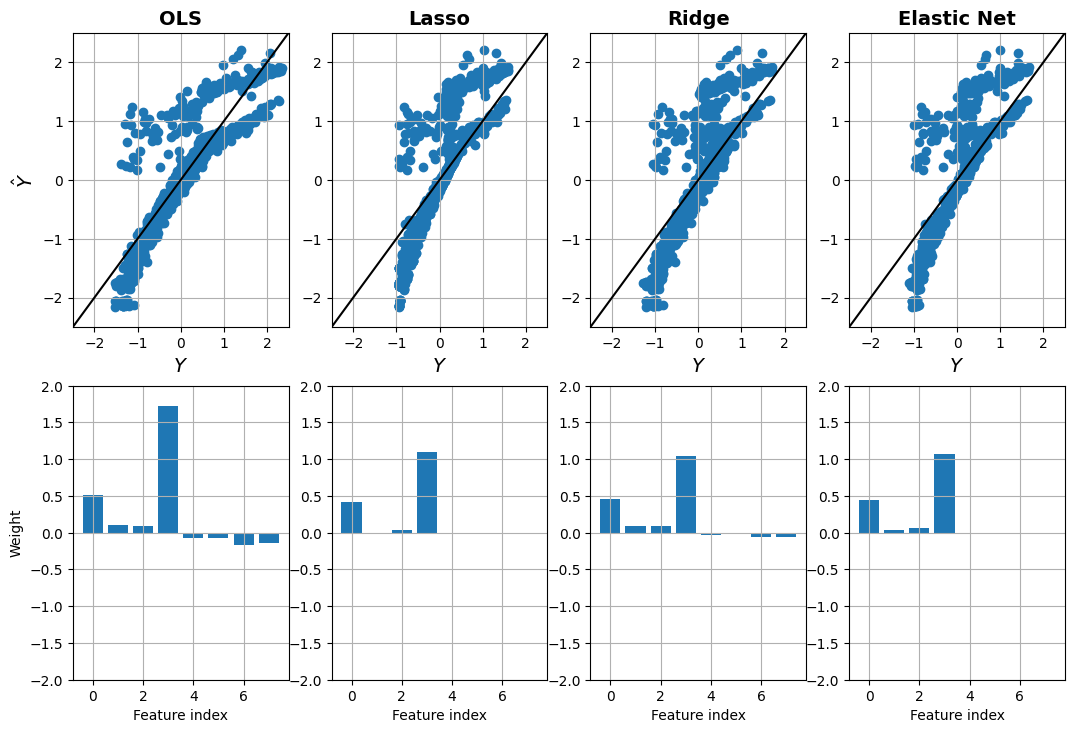

In [22]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12.8, 8.4))

for ind, (axes, (name, model)) in enumerate(zip(axes.T, models.items())):
  # Expected vs predicted
  sc = axes[0]
  Ypred = model.predict(Xtrain)
  sc.scatter(Ypred, Ytrain)
  sc.grid()
  sc.set_xlabel("$Y$", fontsize=14)
  if ind == 0:
    sc.set_ylabel("$\hat{Y}$", fontsize=14)
  sc.set_title(name, fontweight='bold', fontsize=14)
  sc.set(xlim=(-2.5, 2.5), ylim=(-2.5, 2.5))
  sc.plot([0, 1], [0, 1], color='black', transform=sc.transAxes)

  # Weights barplot
  hs = axes[1]
  weights = model.coef_
  hs.bar(np.arange(len(weights)), weights)
  if ind == 0:
    hs.set_ylabel('Weight')
  hs.set(ylim=(-2, 2), xlabel='Feature index')
  hs.grid()

In [23]:
for name, model in models.items():
  l1 = np.abs(model.coef_).sum()
  l2 = np.power(model.coef_, 2).sum()
  print(name)
  print(f"\tl1 -> {l1:.3f}")
  print(f"\tl2 -> {l2:.3f}")

OLS
	l1 -> 2.879
	l2 -> 3.303
Lasso
	l1 -> 1.556
	l2 -> 1.388
Ridge
	l1 -> 1.849
	l2 -> 1.310
Elastic Net
	l1 -> 1.623
	l2 -> 1.361


In [24]:
alpha = 0.1
lm = Lasso(alpha).fit(Xtrain, Ytrain)

# Sanity check
pred = lm.predict(Xtrain)
print(f"MAE: {mean_absolute_error(Ytrain, pred)}")


MAE: 0.3981174381075182


In [25]:
weights = pd.DataFrame({"Weights": lm.coef_, "Features": features})
weights.sort_values("Weights")

,Weights,Features
1,0.000000,bmi
4,-0.000000,sex_male
5,-0.000000,region_northwest
6,-0.000000,region_southeast
7,-0.000000,region_southwest
2,0.034211,children
0,0.422452,age
3,1.099114,smoker_yes
